# Solar Image Dataset Training

In [1]:
# importing modules
import os
import cv2

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf
import pickle
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import (ModelCheckpoint, EarlyStopping, TensorBoard,
    Callback, LearningRateScheduler)

# New Section

In [2]:
tf.version.VERSION

'2.10.1'

In [3]:
print("Number of GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU Available:  1


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

## Dataset

In [5]:
DATASET_PATH = '/sol_data_splitted'

IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 55

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
weight_decay = 0.005
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 25

In [6]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '../sol_data_splitted/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 606 images belonging to 4 classes.


In [8]:
class_names = list(train_generator.class_indices.keys())
class_names

['clean', 'dust', 'shadow', 'waterdrop']

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '../sol_data_splitted/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 74 images belonging to 4 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '../sol_data_splitted/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 80 images belonging to 4 classes.


In [11]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(64, 256, 256, 3)


## Model Training

Models are:
- Sequential CNN
- AlexNet
- VGG16 (Transfer Learning)
- VGG16
- ResNet
- Xception
- Inception

In [12]:
!mkdir checkpoint

A subdirectory or file checkpoint already exists.


In [13]:
# Setting checkpoint & early stopping
checkpoint_path = os.path.join('/checkpoint',
                    'model_best_weights.{epoch:02d}-{accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='accuracy',
    verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='accuracy', patience=5, mode='max')
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
    histogram_freq=1)
callbacks_list = [checkpoint, tensorboard_callback, reduce_lr]

In [14]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    font = {'family': 'Times New Roman', 'size': 22}
    import matplotlib
    matplotlib.rc('font', **font)
    
    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy for {model_name if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss for {model_name if model_name else ""}')
    
    plt.show()

### Power-Net

In [15]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax'),
])

In [16]:
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 96)       0

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/55
10/10 [==============================] - 24s 2s/step - loss: 2.7753 - accuracy: 0.3267 - val_loss: 2.4305 - val_accuracy: 0.3378
Epoch 2/55
10/10 [==============================] - 17s 2s/step - loss: 2.1751 - accuracy: 0.3317 - val_loss: 2.0013 - val_accuracy: 0.3378
Epoch 3/55
10/10 [==============================] - 16s 2s/step - loss: 1.6181 - accuracy: 0.3713 - val_loss: 1.4842 - val_accuracy: 0.4730
Epoch 4/55
10/10 [==============================] - 16s 2s/step - loss: 1.3709 - accuracy: 0.4884 - val_loss: 1.1965 - val_accuracy: 0.5676
Epoch 5/55
10/10 [==============================] - 19s 2s/step - loss: 1.0848 - accuracy: 0.5413 - val_loss: 0.9279 - val_accuracy: 0.5676
Epoch 6/55
10/10 [==============================] - 17s 2s/step - loss: 0.9473 - accuracy: 0.5627 - val_loss: 0.9001 - val_accuracy: 0.5541
Epoch 7/55
10/10 [==============================] - 17s 2s/step - loss: 0.8817 - accuracy: 0.5726 - val_loss: 0.8432 - val_accuracy: 0.5676
Epoch 8/55
10/10 [==

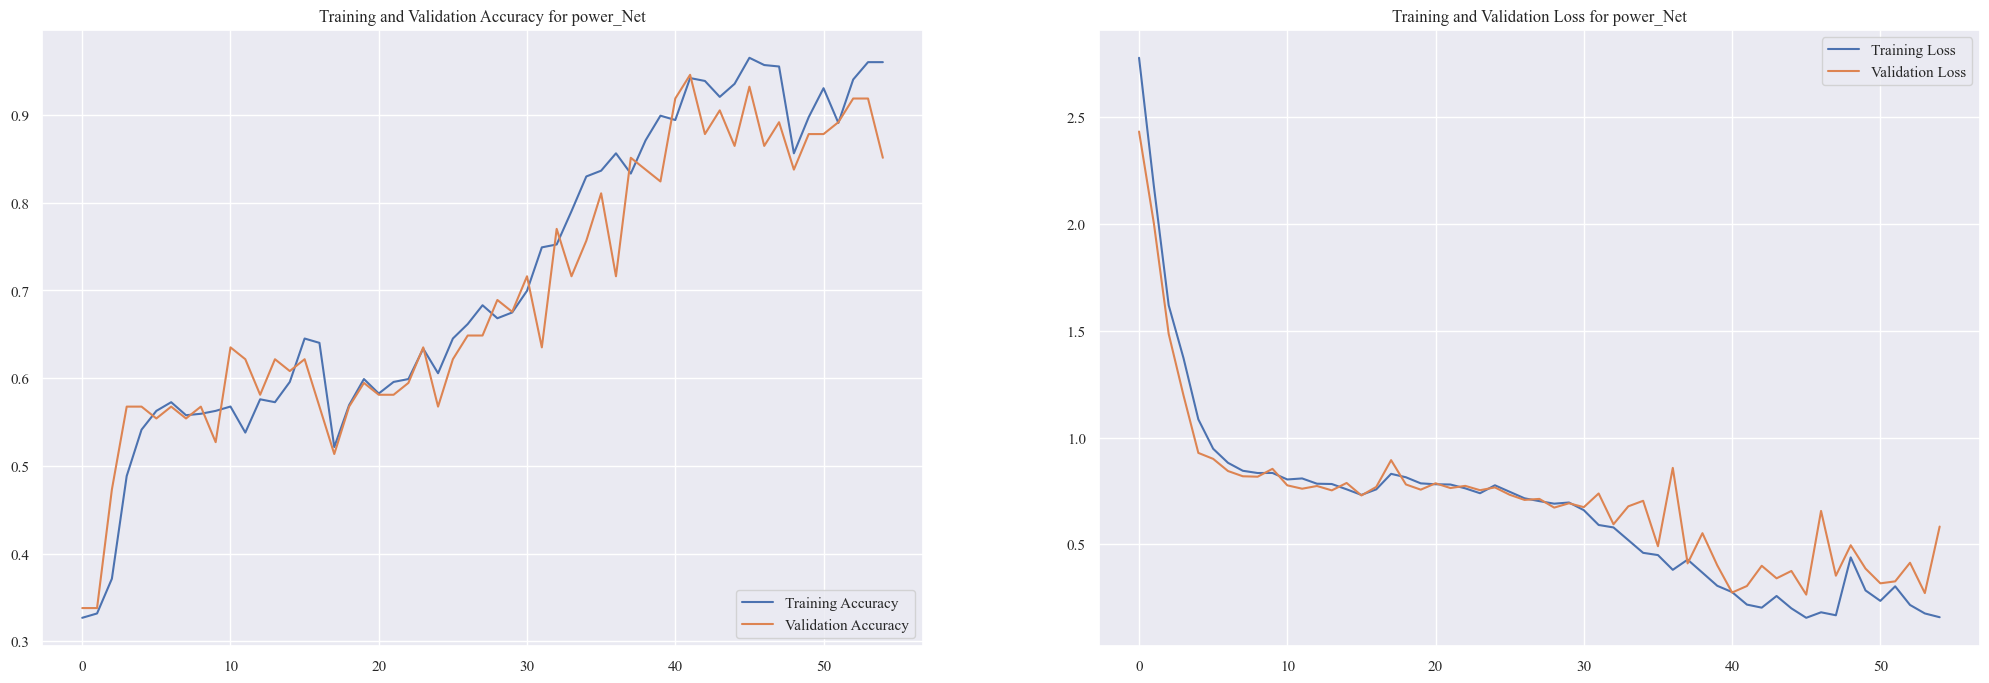

In [20]:
plot_accuracy(history, 'power_Net')

In [21]:
scores= model.evaluate(test_generator)
scores

2/2 [==============================] - 3s 847ms/step - loss: 0.2725 - accuracy: 0.9125


[0.27253371477127075, 0.9125000238418579]

In [22]:
history.params

{'verbose': 1, 'epochs': 55, 'steps': 10}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
len(history.history)

4

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


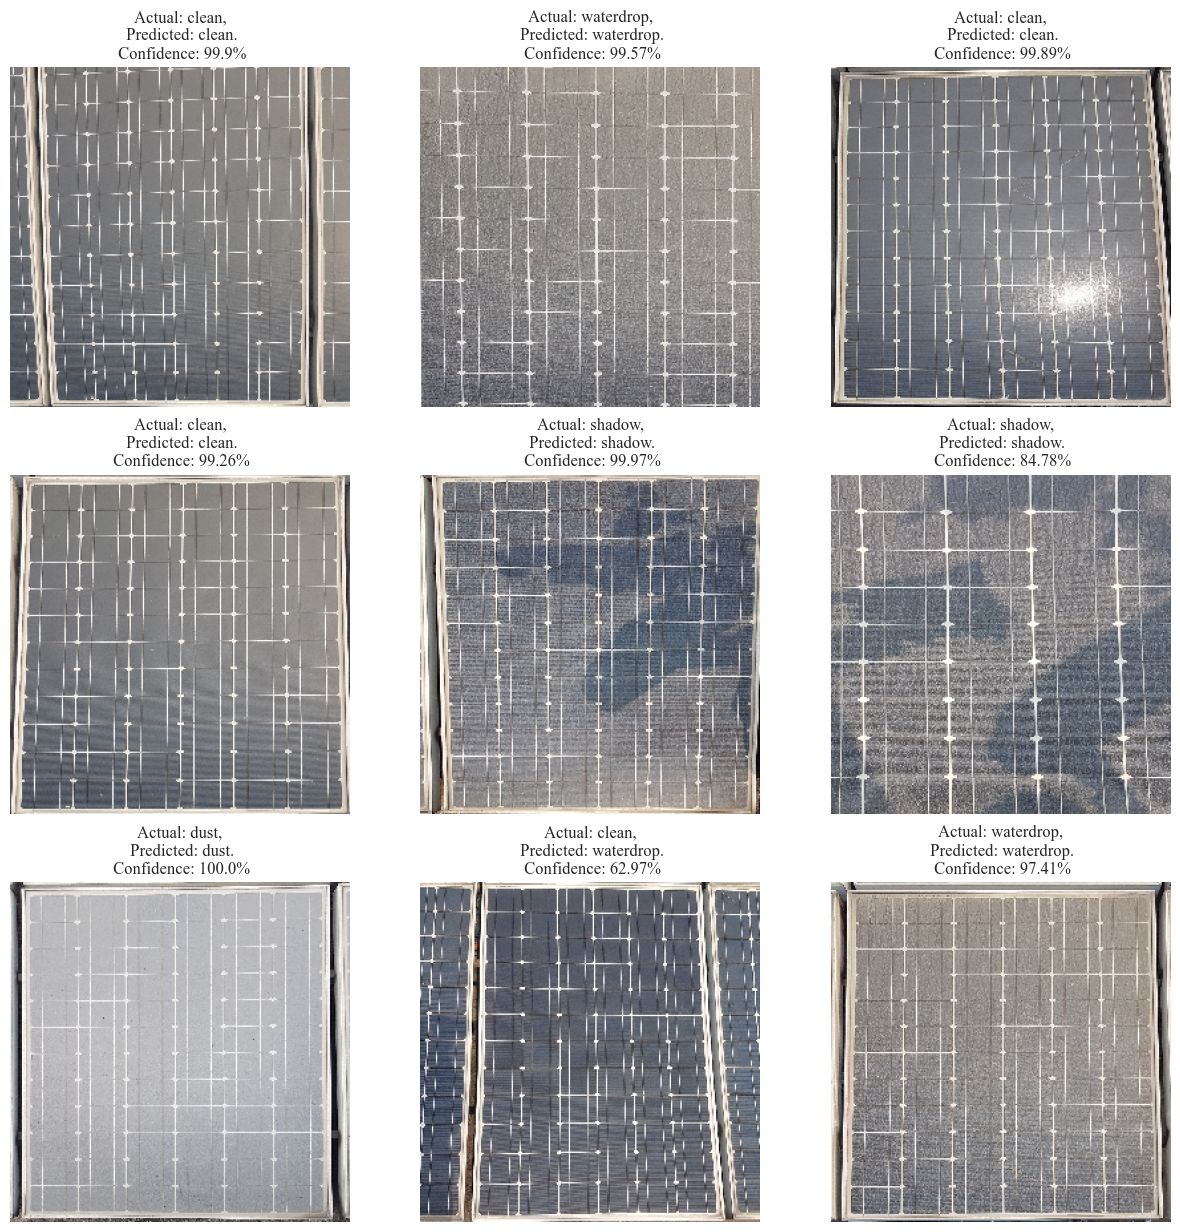

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [28]:
model_version=max([int(i) for i in os.listdir("../save_solar_models") + [0]])+1
model.save(f"../save_solar_models/{model_version}")

INFO:tensorflow:Assets written to: ../save_solar_models/2\assets


INFO:tensorflow:Assets written to: ../save_solar_models/2\assets


In [29]:
model.save("../save_model_pc.h5")

In [30]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
df.head()

,training_acc,val_acc,training_loss,val_loss
0,0.326733,0.337838,2.775323,2.430507
1,0.331683,0.337838,2.175052,2.001269
2,0.371287,0.472973,1.618112,1.484197
3,0.488449,0.567568,1.370889,1.196491
4,0.541254,0.567568,1.084824,0.927939


In [31]:
df.to_csv('power_net_image.csv', index=False)

### REGRESSION

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [33]:
df = pd.read_csv("./metadataclean.csv")
df.head(10)

,Unnamed: 0,panel_name,image_name,lebel,time,LUX,TEMP (Celcius),power
0,0,d-1-3-1,d-1-3-1.jpg,d,1,1350,27.0,23.4639
1,1,d-1-3-2,d-1-3-2.jpg,d,1,1350,27.0,23.4639
2,2,d-1-3-3,d-1-3-3.jpg,d,1,1350,27.0,23.4639
3,3,d-1-3-4,d-1-3-4.jpg,d,1,1350,27.0,23.4639
4,4,d-1-4-1,d-1-4-1.jpg,d,1,1380,27.1,22.2275
5,5,d-1-4-2,d-1-4-2.jpg,d,1,1380,27.1,22.2275
6,6,d-1-4-3,d-1-4-3.jpg,d,1,1380,27.1,22.2275
7,7,d-1-4-4,d-1-4-4.jpg,d,1,1380,27.1,22.2275
8,8,d-1-5-1,d-1-5-1.jpg,d,1,1460,27.3,26.9468
9,9,d-1-5-2,d-1-5-2.jpg,d,1,1460,27.3,26.9468


In [34]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [35]:
df.head(10)

,panel_name,image_name,lebel,time,LUX,TEMP (Celcius),power
0,d-1-3-1,d-1-3-1.jpg,d,1,1350,27.0,23.4639
1,d-1-3-2,d-1-3-2.jpg,d,1,1350,27.0,23.4639
2,d-1-3-3,d-1-3-3.jpg,d,1,1350,27.0,23.4639
3,d-1-3-4,d-1-3-4.jpg,d,1,1350,27.0,23.4639
4,d-1-4-1,d-1-4-1.jpg,d,1,1380,27.1,22.2275
5,d-1-4-2,d-1-4-2.jpg,d,1,1380,27.1,22.2275
6,d-1-4-3,d-1-4-3.jpg,d,1,1380,27.1,22.2275
7,d-1-4-4,d-1-4-4.jpg,d,1,1380,27.1,22.2275
8,d-1-5-1,d-1-5-1.jpg,d,1,1460,27.3,26.9468
9,d-1-5-2,d-1-5-2.jpg,d,1,1460,27.3,26.9468


In [36]:
le = LabelEncoder()
df['lebel'] = le.fit_transform(df['lebel'])

In [37]:
X = df[['lebel','time','LUX','TEMP (Celcius)']]
y = df['power']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### RandomForestRegressor

In [40]:
from sklearn import externals

In [41]:
# import joblib
from sklearn.ensemble import RandomForestRegressor

In [42]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean squared error: 0.5471752781598191
R-squared: 0.9986582427251405


In [44]:
with open("rf_model.pkl", "wb") as file:
    pickle.dump(rfr, file)

In [45]:
with open("rf_model.pkl", "rb") as file:
    rf_model = pickle.load(file)

In [46]:
cnn_model = tf.keras.models.load_model('../save_model_pc.h5')

In [47]:
# filename = 'RandomForestRegressor_model.joblib'
# joblib.dump(rfr, filename)

# # load the model from disk
# loaded_model = joblib.load(filename)

In [48]:
def power_regression_prediction(lebel, time, lux, temp):
    user_input = [[lebel, time, lux, temp]]
    user_input = scaler.transform(user_input)
    power_prediction = rf_model.predict(user_input)
    return power_prediction[0]

In [49]:
from PIL import Image
import numpy as np

def predict_power(image_path, time, lux, temp):
    # Open and preprocess the image
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    class_names=['clean', 'dust', 'shadow', 'waterdrop']
    # Use the CNN model to predict the label of the image
    label_prediction = cnn_model.predict(image_array)
    label = np.argmax(label_prediction)

    # Use the predicted label, time, lux, and temp to predict the power
    power_prediction = power_regression_prediction(label, time, lux, temp)
    return class_names[label], power_prediction

In [51]:
power_prediction = predict_power('D:/400c_data/project/sol_data_splitted/test/shadow/s-1-21-1.jpg', 1, 3000, 22.5)
print("Predicted power:", power_prediction)

1/1 [==============================] - 0s 20ms/step
Predicted power: ('waterdrop', 58.18898499999992)


D:\400c_data\project\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [59]:
# def predict_panel(image, time, lux, temp):
#     img_array = tf.keras.preprocessing.image.img_to_array(image)
#     img_array = tf.expand_dims(img_array, 0)

#     predicted = cnn_model.predict(img_array)
#     class_names=['clean', 'dust', 'shadow', 'waterdrop']
#     class_label=[1, 2, 3, 4]
#     label = class_label[np.argmax(predicted[0])]

#     X_test = np.array([[label, time, lux, temp]])
#     # power_pred = rf_model.predict(X_test)
#     power_pred=rfr.predict(X_test)
#     return class_names[label-1], power_pred


In [ ]:
# import cv2
# im = cv2.imread("/content/sol_data_splitted/train/waterdrop/w-1-6-2.jpg")
# images = cv2.resize(im, (256, 256))
# images = images.astype("float") / 255.0

In [ ]:
# predict_panel(images, 2, 3000, 30)

1/1 [==============================] - 0s 70ms/step


('clean', array([83.600662]))

### Prediction Function

### AlexNet

In [52]:
i = Input(input_shape)
r = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                  input_shape=input_shape)(i)
r = BatchNormalization()(r)
r = Dropout(0.2)(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.4)(r)
r = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.5)(r)
r = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.4)(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Flatten()(r)
r = Dense(4096, activation='relu')(r)
r = Dropout(0.5)(r)
r = Dense(4096, activation='relu')(r)
r = Dropout(0.4)(r)
o = Dense(4, activation='softmax')(r)

alexnet_model = Model(i, o)

In [53]:
alexnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
alexnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 96)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 256)       614656

In [56]:
alexnet_history = alexnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/55
10/10 [==============================] - 17s 2s/step - loss: 2.1840 - accuracy: 0.6832 - val_loss: 296.4575 - val_accuracy: 0.3378
Epoch 2/55
10/10 [==============================] - 16s 2s/step - loss: 2.3031 - accuracy: 0.7013 - val_loss: 245.0122 - val_accuracy: 0.3378
Epoch 3/55
10/10 [==============================] - 16s 2s/step - loss: 1.8291 - accuracy: 0.7013 - val_loss: 155.7572 - val_accuracy: 0.3378
Epoch 4/55
10/10 [==============================] - 16s 2s/step - loss: 1.2068 - accuracy: 0.7409 - val_loss: 115.8421 - val_accuracy: 0.3378
Epoch 5/55
10/10 [==============================] - 16s 2s/step - loss: 1.1891 - accuracy: 0.7360 - val_loss: 97.4742 - val_accuracy: 0.3378
Epoch 6/55
10/10 [==============================] - 16s 2s/step - loss: 1.1205 - accuracy: 0.7607 - val_loss: 46.9619 - val_accuracy: 0.3378
Epoch 7/55
10/10 [==============================] - 16s 2s/step - loss: 0.9212 - accuracy: 0.7673 - val_loss: 50.3788 - val_accuracy: 0.3378
Epoch 8/5

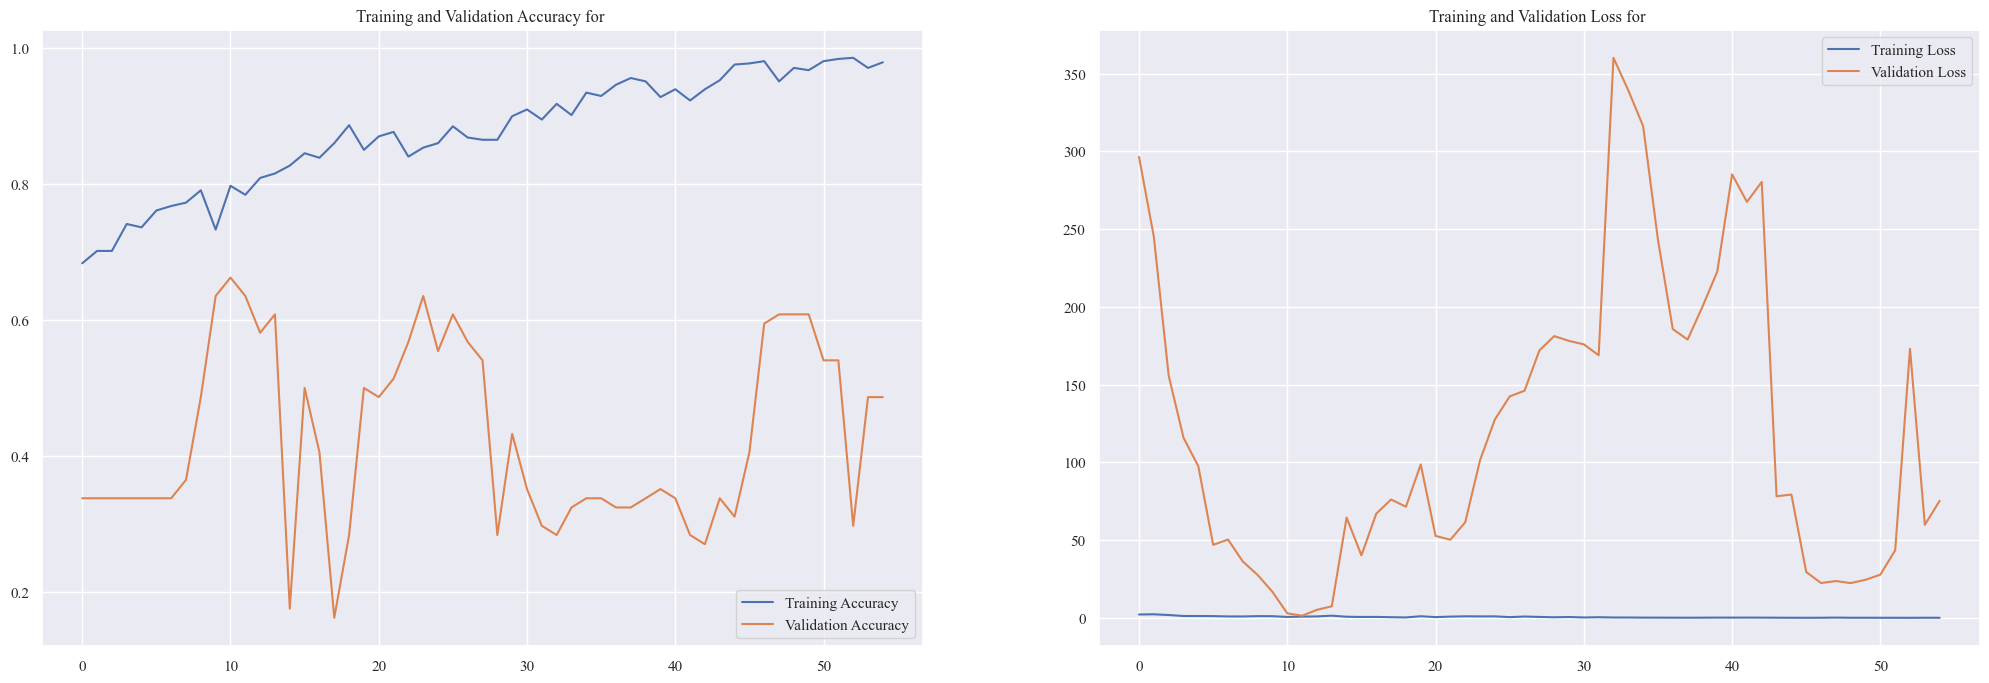

In [57]:
plot_accuracy(alexnet_history)

In [58]:
alexnet_scores= alexnet_model.evaluate(test_generator)
alexnet_scores

2/2 [==============================] - 2s 650ms/step - loss: 53.2971 - accuracy: 0.5250


[53.29706954956055, 0.5249999761581421]

In [59]:
train_acc = alexnet_history.history['accuracy']
val_acc = alexnet_history.history['val_accuracy']

train_loss = alexnet_history.history['loss']
val_loss = alexnet_history.history['val_loss']

df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
df.head()

,training_acc,val_acc,training_loss,val_loss
0,0.683168,0.337838,2.184026,296.457458
1,0.701320,0.337838,2.303133,245.012161
2,0.701320,0.337838,1.829112,155.757156
3,0.740924,0.337838,1.206848,115.842140
4,0.735974,0.337838,1.189120,97.474243


In [60]:
df.to_csv('alexnet_model.csv', index=False)

### VGG16

In [61]:
vgg16_model = Sequential()

vgg16_model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(512))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(3))
vgg16_model.add(Activation('softmax'))

In [62]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0         
                                                      

                                                                 
 dropout_16 (Dropout)        (None, 8, 8, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 activation_13 (Activation)  (None, 512)               0         
                                                                 
 batch_normalization_18 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
          

In [63]:
sgd = optimizers.SGD(learning_rate=learning_rate, decay=lr_decay,
                     momentum=0.8, nesterov=True)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=sgd, metrics=['accuracy'])

In [64]:
vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/55


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/batch_normalization_7/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\400c_data\project\venv\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "D:\400c_data\project\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_20492\3623816291.py", line 1, in <module>
      vgg16_history = vgg16_model.fit(
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "D:\400c_data\project\venv\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "D:\400c_data\project\venv\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/batch_normalization_7/FusedBatchNormV3'
OOM when allocating tensor with shape[30,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/batch_normalization_7/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_19364]

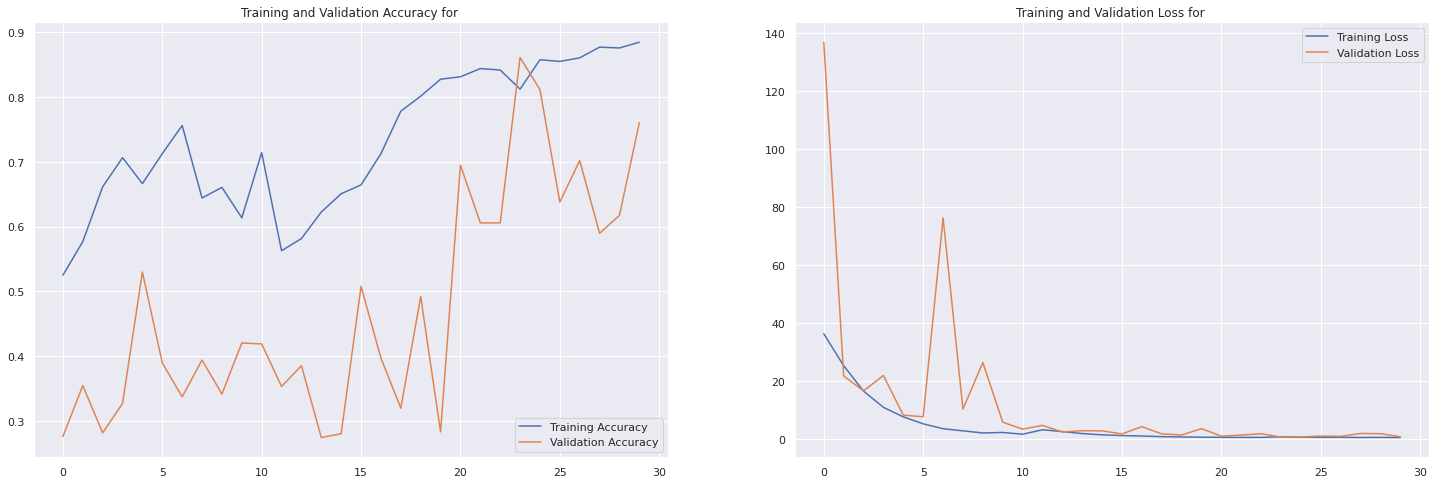

In [ ]:
plot_accuracy(vgg16_history)

In [ ]:
vgg16_scores= vgg16_model.evaluate(test_generator)
vgg16_scores

11/11 [==============================] - 16s 2s/step - loss: 0.8594 - accuracy: 0.7820


[0.8594195246696472, 0.7819767594337463]

### VGG16 Transfer Learning

In [65]:
vgg16_tl = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in vgg16_tl.layers:
    layer.trainable = False

In [66]:
x = Flatten()(vgg16_tl.output)
prediction = Dense(3, activation='softmax')(x)

vgg16_tl_model = Model(inputs=vgg16_tl.input, outputs=prediction)

In [67]:
vgg16_tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [68]:
vgg16_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
vgg16_tl_history = vgg16_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/50
10/10 [==============================] - 39s 3s/step - loss: nan - accuracy: 0.2360 - val_loss: nan - val_accuracy: 0.2162
Epoch 2/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 3/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 4/50
10/10 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 5/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 6/50
10/10 [==============================] - 30s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 7/50
 5/10 [==============>...............] - ETA: 11s - loss: nan - accuracy: 0.1818

KeyboardInterrupt: ignored

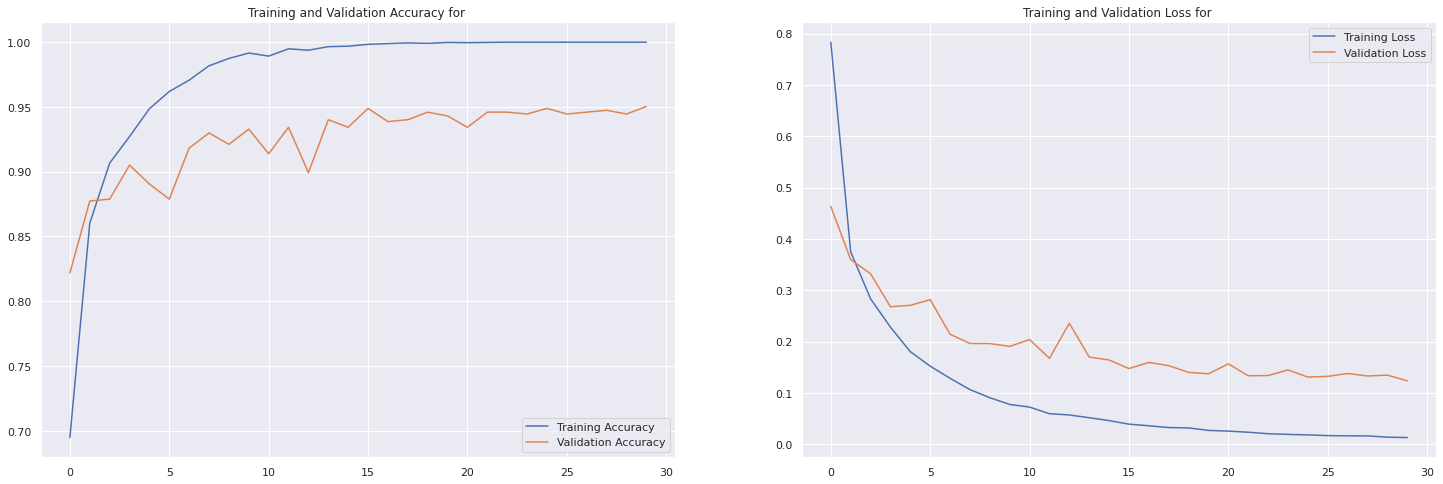

In [ ]:
plot_accuracy(vgg16_tl_history)

In [ ]:
vgg16_tl_scores= vgg16_tl_model.evaluate(test_generator)
vgg16_tl_scores

11/11 [==============================] - 11s 1s/step - loss: 0.0930 - accuracy: 0.9593


[0.09300528466701508, 0.9593023061752319]

### ResNet

In [69]:
def resnet(input_shape, n_classes):
  
    def conv_bn_rl(x, f, k=1, s=1, p='same'):
        x = Conv2D(f, k, strides=s, padding=p)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = ReLU()(x)
        return x


    def identity_block(tensor, f):
        x = conv_bn_rl(tensor, f)
        x = conv_bn_rl(x, f, 3)
        x = Conv2D(4*f, 1)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Add()([x, tensor])
        output = ReLU()(x)
        return output


    def conv_block(tensor, f, s):
        x = conv_bn_rl(tensor, f)
        x = conv_bn_rl(x, f, 3, s)
        x = Conv2D(4*f, 1)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        shortcut = Conv2D(4*f, 1, strides=s)(tensor)
        shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        output = ReLU()(x)
        return output


    def resnet_block(x, f, r, s=2):
        x = conv_block(x, f, s)
        for _ in range(r-1):
            x = identity_block(x, f)
        return x


    input = Input(input_shape)

    x = conv_bn_rl(input, 64, 7, 2)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = resnet_block(x, 64, 3, 1)
    x = resnet_block(x, 128, 4)
    x = resnet_block(x, 256, 6)
    x = resnet_block(x, 512, 3)

    x = GlobalAvgPool2D()(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

In [70]:
resnet_model = resnet(input_shape, 3)

In [71]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [72]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 128, 128, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 64  256        ['conv2d_25[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 re_lu_6 (ReLU)                 (None, 64, 64, 256)  0           ['add_1[0][0]']                  
                                                                                                  
 conv2d_33 (Conv2D)             (None, 64, 64, 64)   16448       ['re_lu_6[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 64, 64, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_25 (Dropout)           (None, 64, 64, 64)   0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 re_lu_7 (

                                                                                                  
 re_lu_14 (ReLU)                (None, 32, 32, 128)  0           ['dropout_32[0][0]']             
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 512)  66048       ['re_lu_14[0][0]']               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_33 (Dropout)           (None, 32, 32, 512)  0           ['batch_normalization_36[0][0]'] 
                                                                                                  
 add_4 (Ad

                                                                                                  
 conv2d_50 (Conv2D)             (None, 16, 16, 256)  590080      ['re_lu_22[0][0]']               
                                                                                                  
 batch_normalization_44 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_41 (Dropout)           (None, 16, 16, 256)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 re_lu_23 (ReLU)                (None, 16, 16, 256)  0           ['dropout_41[0][0]']             
                                                                                                  
 conv2d_51

                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 16, 16, 1024  4096       ['conv2d_58[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 dropout_48 (Dropout)           (None, 16, 16, 1024  0           ['batch_normalization_52[0][0]'] 
                                )                                                                 
                                                                                                  
 add_9 (Add)                    (None, 16, 16, 1024  0           ['dropout_48[0][0]',             
                                )                                 're_lu_27[0][0]']               
          

 ormalization)                                                                                    
                                                                                                  
 dropout_55 (Dropout)           (None, 16, 16, 256)  0           ['batch_normalization_59[0][0]'] 
                                                                                                  
 re_lu_37 (ReLU)                (None, 16, 16, 256)  0           ['dropout_55[0][0]']             
                                                                                                  
 conv2d_66 (Conv2D)             (None, 16, 16, 256)  590080      ['re_lu_37[0][0]']               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_66[0][0]']              
 ormalization)                                                                                    
          

 conv2d_74 (Conv2D)             (None, 8, 8, 2048)   1050624     ['re_lu_44[0][0]']               
                                                                                                  
 batch_normalization_68 (BatchN  (None, 8, 8, 2048)  8192        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_63 (Dropout)           (None, 8, 8, 2048)   0           ['batch_normalization_68[0][0]'] 
                                                                                                  
 add_14 (Add)                   (None, 8, 8, 2048)   0           ['dropout_63[0][0]',             
                                                                  're_lu_42[0][0]']               
                                                                                                  
 re_lu_45 

In [73]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/55


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/dropout_21/dropout/GreaterEqual' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\400c_data\project\venv\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "D:\400c_data\project\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "D:\400c_data\project\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\400c_data\project\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_20492\739093948.py", line 1, in <module>
      resnet_history = resnet_model.fit(
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\400c_data\project\venv\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "D:\400c_data\project\venv\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "D:\400c_data\project\venv\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "D:\400c_data\project\venv\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model_2/dropout_21/dropout/GreaterEqual'
failed to allocate memory
	 [[{{node model_2/dropout_21/dropout/GreaterEqual}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_34624]

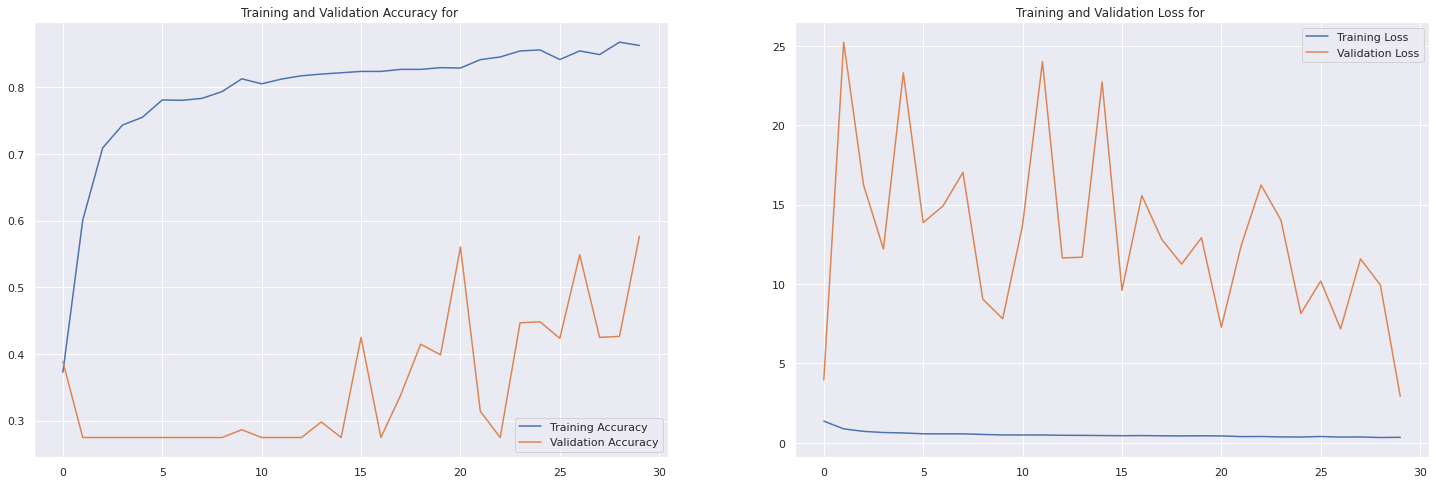

In [ ]:
plot_accuracy(resnet_history)

In [ ]:
resnet_scores= resnet_model.evaluate(test_generator)
resnet_scores

11/11 [==============================] - 5s 471ms/step - loss: 2.8986 - accuracy: 0.5945


[2.89855694770813, 0.5944767594337463]

### ResNet Transfer Learning

In [74]:
ResNet50_tl=tf.keras.applications.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in ResNet50_tl.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 163s 2us/step


In [76]:
x = Flatten()(ResNet50_tl.output)
prediction = Dense(3, activation='softmax')(x)

ResNet50_tl_model = Model(inputs=ResNet50_tl.input, outputs=prediction)

In [77]:
ResNet50_tl_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [78]:
ResNet50_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [80]:
ResNet50_tl_history = ResNet50_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/55
10/10 [==============================] - 19s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 2/55
10/10 [==============================] - 17s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 3/55
10/10 [==============================] - 17s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 4/55
10/10 [==============================] - 17s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 5/55
10/10 [==============================] - 17s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 6/55
10/10 [==============================] - 16s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 7/55
10/10 [==============================] - 16s 2s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 8/55
10/10 [==============================] - 17s 2s/ste

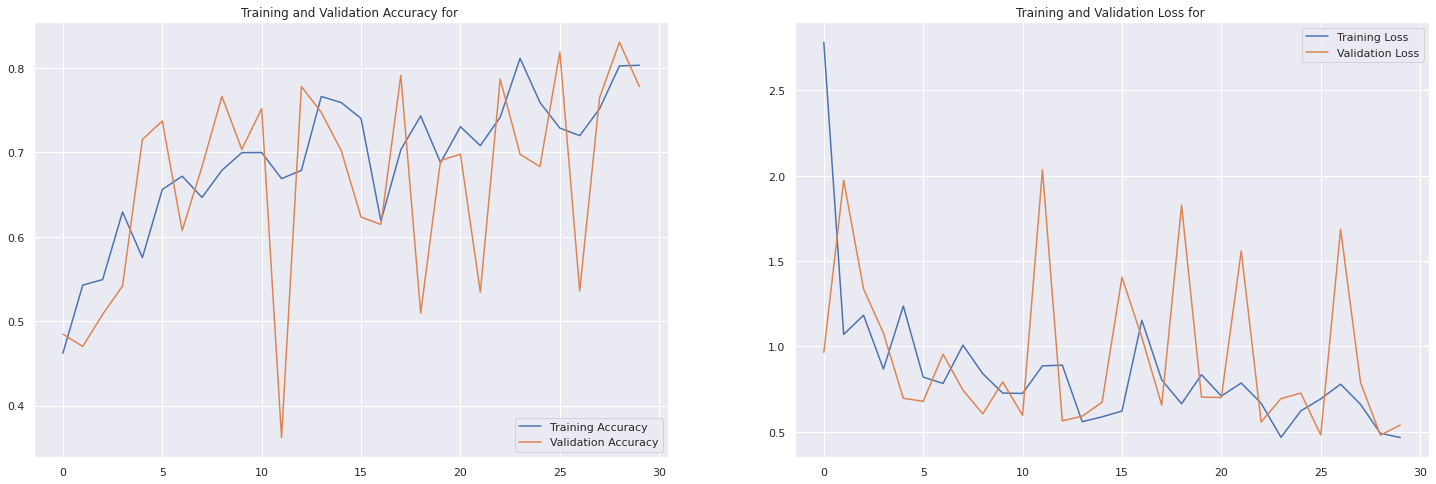

In [ ]:
plot_accuracy(ResNet50_tl_history)

In [ ]:
ResNet50_tl_scores= ResNet50_tl_model.evaluate(test_generator)
ResNet50_tl_scores

11/11 [==============================] - 4s 309ms/step - loss: 0.5050 - accuracy: 0.7965


[0.5050237774848938, 0.7965116500854492]

### InceptionV3-14 Model

In [ ]:
InceptionV3_tl=tf.keras.applications.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in InceptionV3_tl.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
x = Flatten()(InceptionV3_tl.output)
prediction = Dense(3, activation='softmax')(x)

InceptionV3_tl_model = Model(inputs=InceptionV3_tl.input, outputs=prediction)

In [ ]:
InceptionV3_tl_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_53 (BatchN  (None, 127, 127, 32  96         ['conv2d_59[0][0]']              
 ormalization)                  )                                                           

In [ ]:
InceptionV3_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
InceptionV3_tl_history = InceptionV3_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 39s 387ms/step - loss: 4.1218 - accuracy: 0.6440 - val_loss: 0.8514 - val_accuracy: 0.7854
Epoch 2/30
86/86 [==============================] - 28s 328ms/step - loss: 0.4350 - accuracy: 0.8579 - val_loss: 0.5330 - val_accuracy: 0.8482
Epoch 3/30
86/86 [==============================] - 28s 326ms/step - loss: 0.1614 - accuracy: 0.9437 - val_loss: 0.6418 - val_accuracy: 0.8307
Epoch 4/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0579 - accuracy: 0.9803 - val_loss: 0.4819 - val_accuracy: 0.8453
Epoch 5/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0688 - accuracy: 0.9740 - val_loss: 0.4516 - val_accuracy: 0.8701
Epoch 6/30
86/86 [==============================] - 28s 330ms/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.4242 - val_accuracy: 0.8818
Epoch 7/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0068 - accuracy: 0.9998 - val_loss: 0.4332 - val_accuracy: 0.8774

In [81]:
plot_accuracy(InceptionV3_tl_history)

NameError: name 'InceptionV3_tl_history' is not defined

In [ ]:
InceptionV3_tl_scores= InceptionV3_tl_model.evaluate(test_generator)
InceptionV3_tl_scores

11/11 [==============================] - 5s 471ms/step - loss: 0.3240 - accuracy: 0.9055


[0.3240348696708679, 0.9055232405662537]